In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/PU1/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_PU1_H3K27Ac_4month_vs_25month/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in raw peak files

In [3]:
best_reps = ['05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC']

In [4]:
df, mat = read_annotated_peaks('./annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
df.index.rename('PeakID', inplace=True)
# OPTIONAL: drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./annotated_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt', sep='\t')

In [5]:
mat.columns.str.split('/').str[-1]

Index(['05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC'],
      dtype='object')

# Run differential peak analysis

In [6]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./annotated_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt \
# 00_pu1_4month 00_pu1_4month 00_pu1_4month \
# 01_pu1_25month 01_pu1_25month \
# -peaks > ./diff_vw_output.txt

# Create summary plots

## 10day vs. 4 months

In [9]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

# pull distal peaks
diff_peak_distal = diff_peak.reindex(diff_peak.index[np.abs(diff_peak['Distance to TSS']) >= 3*10**3])

annotatePeaks all peaks (27837, 24)
getDiffExpression selected transcripts (27227, 26)
annotatePeaks selected peaks (27227, 24)


In [15]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [16]:
comps = ['00_pu1_4month vs. 01_pu1_25month']

groups = [[[0,1,2],[3,4,5]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)
    
colors = [['#3182bd', '#de2d26']] * len(groups)

00_pu1_4month vs. 01_pu1_25month
N genes downregulated 351
N genes upregulated 1176



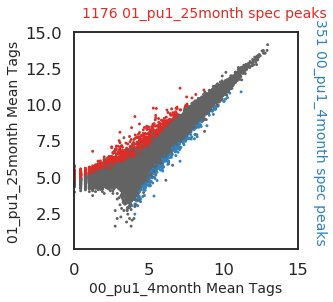

In [17]:
fc = np.log2(2)
pval = 0.05
textax = 16

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,textax,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(textax,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

# Reload peak files
___
This is silly but the above script adds columns we dont want later

In [18]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

# pull distal peaks
diff_peak_distal = diff_peak.reindex(diff_peak.index[np.abs(diff_peak['Distance to TSS']) >= 3*10**3])

annotatePeaks all peaks (27837, 24)
getDiffExpression selected transcripts (27227, 26)
annotatePeaks selected peaks (27227, 24)


In [19]:
comp_dict.keys()

dict_keys(['00_pu1_4month vs. 01_pu1_25month'])

# Extract peaks for an analysis in GREAT

In [20]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_pu1_4month',
         '01_pu1_25month']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_pu1_4month ...

0
For comp: 00_pu1_4month vs. 01_pu1_25month
Union set at: 351 peaks
Intersection set at: 351 peaks

Analyzing 01_pu1_25month ...

0
For comp: 00_pu1_4month vs. 01_pu1_25month
Union set at: 1176 peaks
Intersection set at: 1176 peaks



### Save peak and bed files for GREAT analysis

In [22]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [39]:
convert_dict = {'Start': int,
                'End': int}

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [40]:
for key in peak_lists.keys():
    # save cell specific promoters
    tmp = diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_act_peaks.txt',
               sep='\t')
    tmp = diff_peak_distal.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_act_peaks_distal.txt',
               sep='\t')

Save full set of peaks for background

In [32]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/pu1_all_peaks.txt',
    sep='\t')

Convert to bed files

In [41]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [42]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [43]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [44]:
!cp ./great_analysis/bed_files/*union* ./bed_files/

In [45]:
!ls ./bed_files/

00_pu1_4month_nfr_act_background.bed
00_pu1_4month_nfr_act_background_distal.bed
00_pu1_4month_nfr_act_peaks.bed
00_pu1_4month_nfr_act_peaks_distal.bed
00_pu1_4month_union_act_peaks.bed
00_pu1_4month_union_act_peaks_distal.bed
01_pu1_25month_nfr_act_background.bed
01_pu1_25month_nfr_act_background_distal.bed
01_pu1_25month_nfr_act_peaks.bed
01_pu1_25month_nfr_act_peaks_distal.bed
01_pu1_25month_union_act_peaks.bed
01_pu1_25month_union_act_peaks_distal.bed
fw_peaks_merged.bed
nfr_peaks_merged.bed
vw_peaks_merged.bed


# Give track names for uploading to genome browser

In [27]:
%%bash

echo 'track name="PU1_H3K27Ac_10day_peaks" description="PU1 Nuclei 10day H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/00_pu1_4month_union_act_peaks.bed \
> temp && mv temp ./bed_files/00_pu1_4month_union_act_peaks.bed

echo 'track name="PU1_H3K27Ac_4month_peaks" description="PU1 Nuclei 4month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/01_pu1_25month_union_act_peaks.bed \
> temp && mv temp ./bed_files/01_pu1_25month_union_act_peaks.bed

Next step... check these peaks on browser to make sure they look specific

In [28]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [33]:
diff_peak.sort_values('00_pu1_4month vs. 01_pu1_25month adj. p-value', ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA,00_pu1_4month vs. 01_pu1_25month Log2 Fold Change,00_pu1_4month vs. 01_pu1_25month p-value,00_pu1_4month vs. 01_pu1_25month adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr5-95938589-7,chr5,95933600,95948750,+,370.585724,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,Intergenic,RMER17C|LTR|ERVK,-15764.0,NM_018866,...,8.037127,7.972505,7.881544,10.161278,10.460893,9.851058,2.682115,2.258626e-69,6.131041e-65,chr5:95933600-95948750
Merged-chr5-95898450-5,chr5,95895696,95902529,+,192.839996,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,Intergenic,Intergenic,-57827.0,NM_018866,...,6.666530,6.733547,6.833512,8.687152,8.844153,8.383505,2.887059,1.652663e-47,2.243077e-43,chr5:95895696-95902529
Merged-chr17-28427587-8,chr17,28415198,28439394,+,1570.625000,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,"intron (NM_010220, intron 5 of 10)",(ATG)n|Simple_repeat|Simple_repeat,58853.0,NM_010220,...,11.771821,11.857495,11.686182,10.955291,11.003436,11.010808,-0.840145,1.125629e-38,1.018507e-34,chr17:28415198-28439394
Merged-chr19-29477918-3,chr19,29474679,29481013,+,198.266663,./peak_files/07_mouse_BL6_M_25month_PU1_ChIP_H...,Intergenic,IMPB_01|Satellite|Satellite,44141.0,NR_015567,...,5.861839,6.016613,6.031135,7.737366,8.339057,7.837798,3.885607,1.955075e-38,1.326763e-34,chr19:29474679-29481013
Merged-chr19-32951249-6,chr19,32946264,32957299,+,654.483337,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,Intergenic,L1M4|LINE|L1,194204.0,NM_008960,...,10.186916,10.171119,10.118138,9.220069,9.160087,9.255558,-1.085413,8.462032e-36,4.594037e-32,chr19:32946264-32957299
Merged-chr7-17058238-6,chr7,17055296,17061796,+,503.649994,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,"intron (NM_001162950, intron 1 of 14)","intron (NM_001162950, intron 1 of 14)",-1867.0,NM_016868,...,9.794259,9.870115,9.744158,8.611214,8.641885,8.858652,-1.299024,2.228644e-34,1.008276e-30,chr7:17055296-17061796
Merged-chr19-45838954-10,chr19,45829335,45846671,+,579.770020,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,"intron (NM_198296, intron 24 of 25)","intron (NM_198296, intron 24 of 25)",-21940.0,NM_145703,...,10.834803,10.907391,10.580425,9.807467,9.757198,9.787756,-1.107809,3.139427e-34,1.217425e-30,chr19:45829335-45846671
Merged-chr2-13786884-7,chr2,13781425,13794012,+,304.800018,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,"intron (NM_145838, intron 2 of 7)","intron (NM_145838, intron 2 of 7)",5802.0,NM_145838,...,8.461034,8.214306,8.167920,9.578871,9.840309,9.454094,1.648552,6.469928e-32,2.195327e-28,chr2:13781425-13794012
Merged-chr10-41597594-7,chr10,41593793,41600942,+,291.000000,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,"intron (NM_001358562, intron 30 of 47)","intron (NM_001358562, intron 30 of 47)",29351.0,NR_045341,...,9.221939,9.510630,9.129220,7.836531,7.991669,8.133050,-1.632472,9.468216e-32,2.855719e-28,chr10:41593793-41600942


This looks good overall - for some of the downregulated peaks the 31 month sample could be more of an outlier. Could be worth seeing what the data looks like without.  

**with 31 month sample**  
863 peaks up in 25mo +  
317 peaks up in 4 month  
  
**When 31month is not included**  
1176 peaks up in 25 mo  
351 peaks up in 4 month  

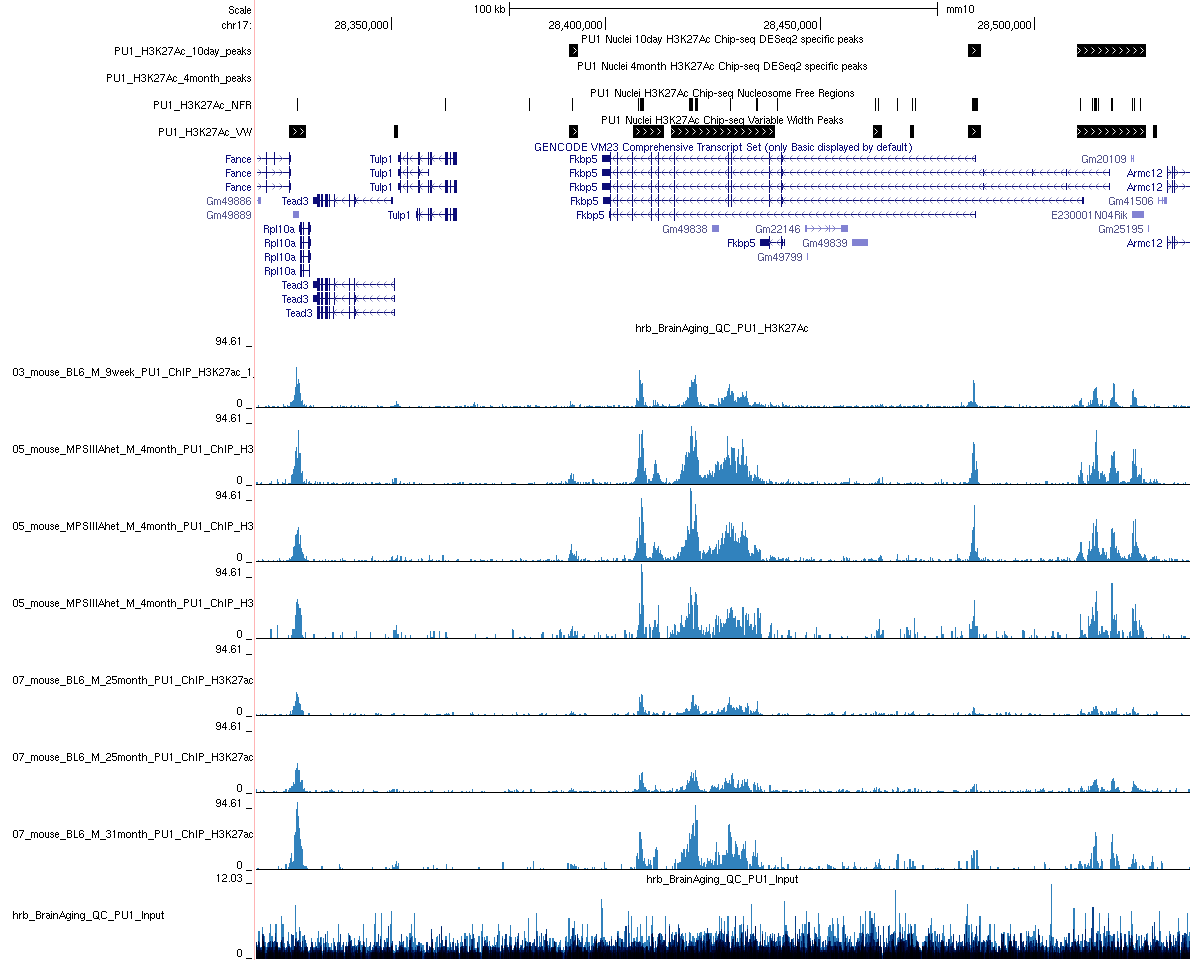